<div class="alert alert-block alert-info">
This tutorial includes 9 lab questions. The question sections have headers like <font color='red'><b>Lab questions, part 1</b></font> in red font (there are 3 parts). Some are challenge questions, and so are required for grad students and honors students. See directions about which ones are required, and which are ones where you choose just one...  Submit your answers via WebCT and remember to paste in the question text (that really helps me grade faster!).  
</div>

# Neural networks, Part 3 -- training networks for non-linearly separable mappings

---

In the previous notebook, we saws that the functions OR, AND, and NAND are linearly separable (LS) and we can find weights for them in single-layer (input-output) networks (perceptrons) using a simple training algorithm (the perceptron learning rule). However, XOR is not LS and we saw that we could not find effective weights using the perceptron learning rule. However, we did see that we could create a 2-layer network (inputs to hidden and hidden to output) and set the weights such that the hidden layer nodes were the results of tests for OR and NAND, and we could combine them (testing for OR **AND** NAND) to implement XOR (when both OR and NAND are true, those are cases where XOR is true). 


In this notebook, we will move on to training methods that *can* find weights for non-linearly separable (NLS) mappings. This is going to require us to move beyond simple 


---

# Gradient Descent and Backpropagation

## Introduction
Gradient descent and backpropagation are fundamental concepts in machine learning and neural networks. They are tools for *minimizing the error in predictions* by iteratively adjusting the weights of the network. Let's start with metaphorical/conceptual treatment of these ideas.

## Gradient Descent

### Concept
Imagine you're on a mountain and you are challenged to move to the lowest point of the valley. You don't have a topographic map, so what can you do? You move in the direction where the slope descends the most. Once you reach the nearest low point, you re-evaluate and aim for the lowest point you can reach from your new location. You keep doing this until you get to the lowest point there seems to be. 

This process is akin to what gradient descent does. To complete the analogy, we can think of the errors as forming a surface.

#### Error Surface in Machine Learning

***Error or Loss Function***. This is a mathematical function that quantifies the difference between the predicted outputs of the model and the actual target values. Common examples include mean squared error for regression tasks and cross-entropy loss for classification tasks (google it if you are curious!).

***Parameters or Weights***. These are the variables within the model (such as a neural network) that are adjusted during training. The goal of training is to find the set of parameters that minimizes the error (that is, that yield outputs that are as close as possible to the desired outputs).

***Error Surface***. This surface represents how the error changes with respect to the model's parameters. In a simple model with two parameters, this surface can be visualized in three dimensions: two axes represent the parameters (the weights), and the third axis represents the error. In more complex models, the error surface exists in high-dimensional space. Let's look at an example using 2d (2 weights) plus error (3d).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# Sample data
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])  # Feature set
y = np.array([6, 8, 9, 11])                     # Target values

# Mean Squared Error function
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Model prediction
def model_prediction(X, w1, w2):
    return w1 * X[:, 0] + w2 * X[:, 1]

# Generating a range of weight values
w1 = np.linspace(-10, 10, 400)
w2 = np.linspace(-10, 10, 400)

# Creating a meshgrid for the weights
W1, W2 = np.meshgrid(w1, w2)

# Calculating the error for each combination of weights
errors = np.array([mse(y, model_prediction(X, w1, w2)) for w1, w2 in zip(np.ravel(W1), np.ravel(W2))])
Z = errors.reshape(W1.shape)

def plot_surface(elev=30, azim=30):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(W1, W2, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    ax.set_zlabel('Error')
    ax.set_title('Error Surface')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interact(plot_surface, elev=(0, 90), azim=(0, 90))


interactive(children=(IntSlider(value=30, description='elev', max=90), IntSlider(value=30, description='azim',…

<function __main__.plot_surface(elev=30, azim=30)>

So the idea here is that at different weight combinations, we get different amounts of error. If we had a way to detect the gradient in every direction from our current location (our address in terms of weight 1 and weight 2), we could use the strategy of moving down the surface until we can go no lower. In this particular surface, things are very smooth, and there's a large region that is smoothly near the lowest point. So the goal is to change the weights until we are in that region. If we start at a random position, we don't want to move up in the error dimension. Here's another example that generates a more complex surface.



## Characteristics

1. **Shape**: The shape of the error surface depends on the model architecture and the data. It can have flat areas, steep slopes, valleys, and *local minima* (think of this as a little valley on a plateau that might seem like the lowest point, but if we could see off the plateau, we'd know that there are lower points farther away).

2. **Global vs. Local Minima**: The very lowest point on the error surface represents the *global minimum*. However, there can also be local minima, which are not the optimal set of parameters but are lower than the surrounding points.

3. **Gradient Descent**: Optimization algorithms like gradient descent navigate this surface by iteratively moving in the direction that reduces the error, using the gradient to determine the direction.

## Importance in neural networks

In neural networks, the error surface can be very complex due to the high number of parameters and non-linear transformations. Understanding this surface helps in designing optimization algorithms and model architectures, like selecting activation functions and initialization methods that lead to more favorable error surfaces. We will need an algorithm that can avoid getting stuck in local minima. 

The *learning rate* ($\eta$, 'eta') determines how far we move on the error surface at any point because it governs how much we change the weights. Think of it as the *step size*: how far you step as you look for the lowest point (if it's hard to think about this because we could obviously adjust how far we step, imagine you are in a machine that hops, and there is a minimum hop size). If we set it too low, it may take a long time to explore the surface, or we might get stuck in a local minimum. If we set it too large, we might repeatedly jump over lower points.  

### Mathematics
Consider a function $f(\mathbf{x})$ that we want to minimize. Here, $\mathbf{x}$ represents the parameters of our model. The gradient (denoted by $\nabla f(\mathbf{x})$) points in the direction of the steepest ascent. To find the minimum, we update $\mathbf{x}$ in the opposite direction:

$$
\mathbf{x}_{\text{new}} = \mathbf{x} - \eta \nabla f(\mathbf{x})
$$

Here, $\eta$ is the learning rate, a small positive value that determines the size of each step.

### Learning rate redux
The learning rate is crucial: too small, and the algorithm takes too long to converge; too large, and it might overshoot the minimum.

---

## Backpropagation

### Concept
Backpropagation is a method for calculating the gradient of the error function in neural networks. It’s like solving a complex puzzle by working backwards. After comparing the output of the network with the desired output, the algorithm calculates how much each neuron's activity contributed to the error and adjusts the weights accordingly. The algorithm figures out how much each weight contributed to the ultimate error, and changes each weight slightly in the direction that would lead to lower error if the same pattern were input again. 

### Mathematics
Consider a neural network with weights $\mathbf{W}$ and a loss function $L$. Backpropagation involves computing the derivative of the loss with respect to the weights, denoted as $\frac{\partial L}{\partial \mathbf{W}}$. This derivative tells us how to update the weights to reduce the error.

<div class="alert alert-block alert-info">

## Understanding Derivatives

A derivative is a fundamental concept in calculus that describes how a function changes as its input changes. It is a measure of the rate at which a function's value changes at a certain point.

### Basic Idea

- **Instantaneous Rate of Change**: The derivative of a function at a point is the instantaneous rate of change of the function's value with respect to changes in its input at that point. It's like measuring the slope of the function at a particular point.
    
- **Slope of the Tangent Line**: Geometrically, the derivative at a point corresponds to the slope of the tangent line to the function at that point. If you graph the function, the tangent line at a point is a straight line that just "touches" the curve at that point without crossing it. The slope of this tangent line is the derivative.

*The next code block makes a plot to demonstrate this.*
    
</div>

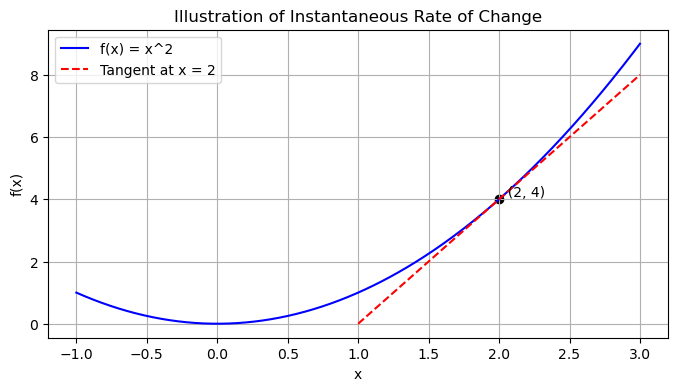

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function and its derivative
def f(x):
    return x ** 2

def df(x):
    return 2 * x

# Define the point at which we calculate the derivative
x0 = 2
y0 = f(x0)
slope = df(x0)

# Define the tangent line at x0
def tangent_line(x):
    return slope * (x - x0) + y0

# Generate x values
x = np.linspace(-1, 3, 400)

# Plot the function
plt.figure(figsize=(8, 4))
plt.plot(x, f(x), label="f(x) = x^2", color="blue")

# Plot the tangent line
x_tangent = np.linspace(1, 3, 10)
plt.plot(x_tangent, tangent_line(x_tangent), label="Tangent at x = 2", color="red", linestyle="--")

# Highlight the point of tangency
plt.scatter([x0], [y0], color="black")
plt.text(x0, y0, f"  ({x0}, {y0})", verticalalignment='bottom')

# Add labels and title
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Illustration of Instantaneous Rate of Change")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">


### Mathematical Representation
    
- **Notation**: If $f(x)$ is a function, its derivative is commonly denoted as $f'(x)$, $\frac{df}{dx}$, or $Df(x)$.

- **Limit Definition**: Mathematically, the derivative of $f$ at a point $x$ is defined as the limit of the average rate of change of the function over an interval as the interval becomes infinitesimally small:
  $$
  f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
  $$

### Interpretation and Applications

- **Physical Interpretation**: In physics, the derivative of the position of an object with respect to time is its velocity, representing how quickly the position changes over time.

- **General Applications**: Derivatives are used in a wide range of fields, from physics and engineering to economics and biology, for modeling and understanding how changes in one quantity lead to changes in another.

- **Simple Example**: For the function $f(x) = x^2$, the derivative $f'(x)$ is $2x$. This means that at any point $x$, the rate at which $f(x)$ changes is $2x$.

In summary, derivatives provide a powerful way to analyze and predict the behavior of functions, particularly in understanding and quantifying how changes in variables affect the outcome of the function.

</div>

### Backprop update rule

The update rule is similar to gradient descent:

$$
\mathbf{W}_{\text{new}} = \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$

Here, $\eta$ is the learning rate.

### Intuition
The power of backpropagation lies in its ability to handle complex networks. By breaking the problem into smaller parts (chain rule in calculus), it calculates the gradient for each weight efficiently.

## Conclusion
In summary, gradient descent is like finding the best path downhill, and backpropagation is about understanding each step's contribution to a misstep. Together, they form the backbone of training neural networks.

# Derivatives of Sigmoid and Tanh Functions

The functions `sigmoid_derivative` and `tanh_derivative` in code blocks below are used to calculate the derivatives of the sigmoid and hyperbolic tangent (tanh) functions, respectively. These derivatives are crucial in neural networks, especially during backpropagation. Let's explore how these derivatives are calculated. First, here's the code -- it's suprisingly simple. (Note that `np` here is a `numpy` function, since we will `import numpy as np` later.)

```python
    # need the derivatives for backpropogation 
    def sigmoid_derivative(x):
        return x * (1 - x)
    
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2
```

## Derivative of the sigmoid function

- The sigmoid function is defined as $ \sigma(x) = \frac{1}{1 + e^{-x}} $.
- The derivative of the sigmoid function, $ \sigma'(x) $, is $ \sigma(x) \cdot (1 - \sigma(x)) $. This derivative is derived using the chain rule in calculus.
- In practice, when implementing backpropagation, we often already have the sigmoid output computed during the forward pass. Hence, instead of recalculating $ \sigma(x) $, the derivative is computed as `x * (1 - x)`, where `x` is actually $ \sigma(x) $.

## Derivative of the tanh function

- The hyperbolic tangent function is defined as $ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $.
- The derivative of the tanh function, $ \tanh'(x) $, is $ 1 - \tanh(x)^2 $. This also results from applying the chain rule.
- Similar to the sigmoid case, if we have the value of $ \tanh(x) $ from the forward pass, the derivative at that point can be computed efficiently as `1 - np.tanh(x)**2`.


# Implementing Backpropagation in Python

Backpropagation is a key method used in training artificial neural networks. It involves a forward pass to compute the output, and a backward pass to update the network's weights based on the error. Below is a step-by-step guide to implement backpropagation in Python:

## Step 1: Forward pass
- **Initialize Network**: Create the structure of the neural network with initialized weights and biases.
- **Input Layer**: Feed the input data into the network.
- **Hidden Layers**: Calculate the output of each neuron in the hidden layers, using a weighted sum of inputs and an activation function. For instance, with a sigmoid activation function:

```python
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
```

- **Output Layer**: Compute the network's final output.

## Step 2: Compute loss (error)
- **Calculate Error**: Determine the network's error using a loss function, like mean squared error (MSE) for regression problems:

```python
    def mse(target, output):
        return np.mean(np.power(target-output, 2))
```


## Step 3: Backward pass
- **Output Layer Error**: Determine the error contribution of the output layer.
- **Backpropagate Error**: For each layer, starting from the output and moving backwards, calculate:
- The error contribution of each neuron.
- The gradient of the activation function. For a sigmoid, it's:

  
```python
    def sigmoid_derivative(output):
        return output * (1 - output)
```


- Update weights and biases based on the error and derivative:

```python
    weights -= learning_rate * error * derivative
```


## Step 4: Update Weights
- **Apply Gradient Descent**: Adjust the network's weights using the gradients calculated during backpropagation.
- **Learning Rate**: Control the weight adjustment magnitude with a learning rate.

## Example code
Here's a simplified example of backpropagation for a single neuron:

```python
    def backpropagate(input, weight, expected_output, output, learning_rate):
        # Calculate error
        error = expected_output - output
    
        # Derivative for sigmoid activation
        derivative = output * (1 - output)
    
        # Update weight
        weight += learning_rate * input * error * derivative
    
        return weight
```


---

### Activation functions

A subtle but important consideration is the activation function used for nodes at various levels within a network. The next code block defines a function that generates figures to demonstrate different activation functions. Run it now so that the function is defined, and we will call it (execute it) later. 

In [4]:
def make_activation_plots():

    import numpy as np
    import matplotlib.pyplot as plt

    # Activation functions
    def linear_activation(x):
        return x

    def step_activation(x, thresh=0.5):
        return np.where(x > thresh, 1, 0)

    def sigmoid_activation(x):
        return 1 / (1 + np.exp(-x))

    def tanh_activation(x):
        return np.tanh(x)

    def relu_activation(x):
        return np.maximum(0, x)

    # Generating values from -10 to 10
    x = np.linspace(-6, 6, 100)

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Function to add annotations
    def add_annotation(ax, formula, xpos=0.5, ypos=0.15, fontsize=16, alpha=0.8):
        ax.text(xpos, ypos, formula, horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, 
                fontsize=fontsize, bbox=dict(facecolor='white', alpha=alpha))

    # Function to add grey dashed lines
    def add_zero_lines(ax):
        ax.axhline(y=0, color='lightgrey', linestyle='--', linewidth=1)
        ax.axvline(x=0, color='lightgrey', linestyle='--', linewidth=1)

    # Linear
    axes[0,0].plot(x, linear_activation(x))
    axes[0,0].set_title('Linear Activation')
    add_annotation(axes[0,0], 'f(x) = x', 0.75)

    # Step
    axes[0,1].plot(x, step_activation(x, 0.5))
    axes[0,1].set_title('Step Activation (0.5)')
    add_annotation(axes[0,1], 'f(x) = 1 if x > 0.5\n       else 0', 0.8, 0.2, alpha=1, fontsize=16)

    # Sigmoid
    axes[0,2].plot(x, sigmoid_activation(x))
    axes[0,2].set_title('Sigmoid Activation')
    #add_annotation(axes[0,2], 'f(x) = 1 / (1 + exp(-x))', 0.65, 0.15)
    add_annotation(axes[0,2], 'f(x) = $\\frac{1}{1 + e^{-x}}$', 0.75, fontsize=20)

    # ReLU
    axes[1,0].plot(x, relu_activation(x))
    axes[1,0].set_title('ReLU Activation')
    add_annotation(axes[1,0], 'f(x) = max(0, x)', 0.3, 0.4)

    # Step
    axes[1,1].plot(x, step_activation(x, -1.5))
    axes[1,1].set_title('Step Activation (-1.5)')
    add_annotation(axes[1,1], 'f(x) = 1 if x > -1.5\n       else 0', 0.8, 0.2, fontsize=16, alpha=1)

    # Tanh
    axes[1,2].plot(x, tanh_activation(x))
    axes[1,2].set_title('Tanh Activation')
    add_annotation(axes[1,2], 'f(x) = $\\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$', 0.75, fontsize=20)

    for ax_x in range(2):
        for ax_y in range(3):
            add_zero_lines(axes[ax_x,ax_y])


    # Adjusting layout
    plt.tight_layout()
    plt.show()


The choice of activation functions in neural networks is crucial as they determine how the network processes inputs and learns. Different activation functions have characteristics that may make them more or less suitable for specific tasks or layers in a neural network. For example, backprop depends on calculating derivatives, so whether an activation function is *differentiable* (yields valid derivatives) throughout its entire range, only part of its range, or not at all has important implications. 

Here's an overview of why we might use different activation functions, including linear, threshold, ReLU, sigmoid, or tanh, for hidden and/or output units:

- **Linear Activation Function**:
   - **Use**: Often used in the output layer for regression tasks where the goal is to predict continuous values.
   - **Characteristics**: It’s a simple identity function that doesn’t alter the weighted sum of the input. This function is useful when the range of output is not confined to a specific range.
   - **Considerations**: This function is differentiable. Its derivative is constant, which allows for backpropagation. However, its use can lead to issues in deep networks due to lack of non-linearity.

- **Step (threshold) Activation Function**:
   - **Use**: Primarily used in binary classification tasks or perceptrons. It’s less common in modern deep learning models.
   - **Characteristics**: It’s a simple function that outputs a binary result based on a threshold. This function can create clear, binary decisions, but it lacks the ability to capture the nuances in data due to its non-continuous and non-differentiable nature.
   - **Considerations**: Not differentiable, and hence, not typically used in networks trained with backpropagation. Modern neural networks rely on differentiable activation functions like ReLU, sigmoid, and tanh, which allow for effective gradient-based optimization during training.

- **ReLU (Rectified Linear Unit) Activation Function**:
   - **Use**: Widely used in hidden layers of neural networks.
   - **Characteristics**: ReLU is defined as the positive part of its argument. It helps with the vanishing gradient problem, allowing models to learn faster and perform better. However, it can suffer from the "dying ReLU" problem, where neurons stop responding to variations due to negative input values.
   - **Considerations**: ReLU is 'piecewise' differentiable. It can be used in backpropagation, although it has a derivative of zero for all negative inputs, which can lead to neurons that never activate (the dying ReLU problem).
   
- **Sigmoid Activation Function**:
   - **Use**: Commonly used in the output layer for binary classification problems.
   - **Characteristics**: It maps the input values to a range between 0 and 1, making it a good choice for probabilities. However, it suffers from the vanishing gradient problem when dealing with deep networks or values that fall off the range of the linear region of the function.
   - **Considerations**: The sigmoid function is differentiable across its entire domain. Its smooth gradient prevents sharp jumps during learning.
   
- **Tanh (Hyperbolic Tangent) Activation Function**:
   - **Use**: Often used in hidden layers.
   - **Characteristics**: It’s similar to the sigmoid function but maps the input values to a range between -1 and 1. This characteristic means that the tanh function is zero-centered, making it easier to model inputs that have strongly negative, neutral, and strongly positive values. Like the sigmoid, it also suffers from the vanishing gradient problem for extreme values.
   - **Considerations**: Like the sigmoid, the tanh function is also differentiable across its entire input range and provides a smooth gradient. In some cases, tanh may be superior to sigmoid because it *tends* (in my experience) to lead to fewer weights with values close to zero. 
   
The choice of activation function depends on the specific requirements of the neural network task. Linear functions are suitable for regression, threshold functions for simple binary decisions, ReLU for faster learning in hidden layers, sigmoid for binary classification, and tanh for cases where zero-centered outputs are beneficial. The key is to match the function's properties to the task's needs, considering factors such as output range, learning speed, and the ability to handle gradients effectively.

*To see the functions, execute* `make_activation_plots()` *in the next cell.*

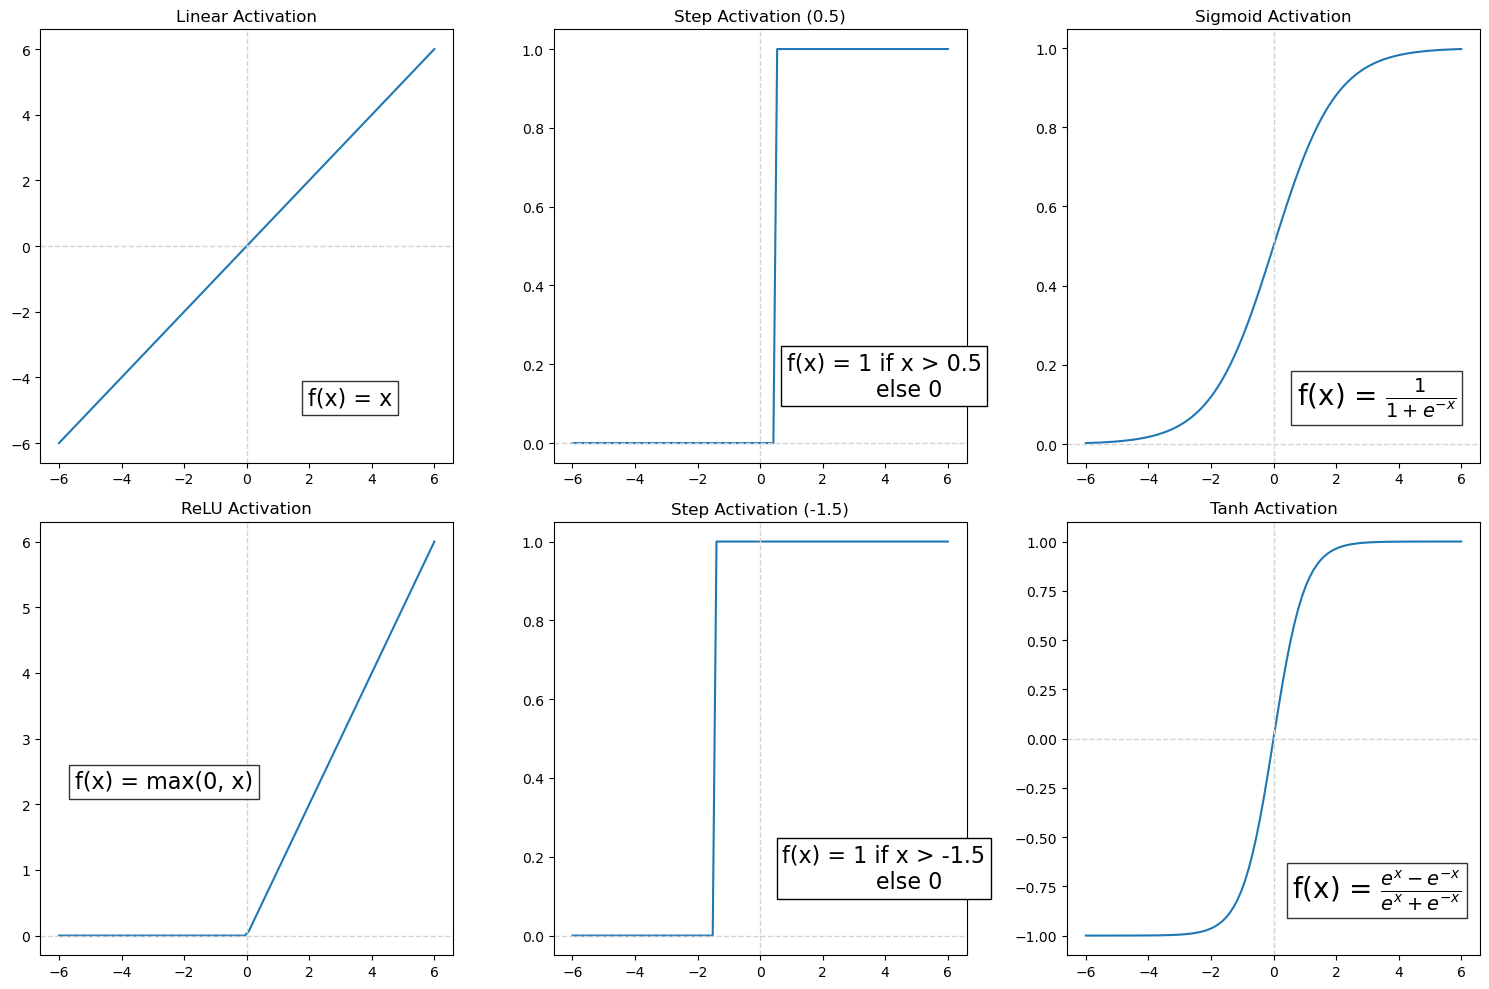

In [5]:
make_activation_plots()

---
<div class="alert alert-block alert-info">

## An aside -- random seeds in programming

Random seeds are an essential concept in Python and other programming languages, particularly when working with random number generation. They play a crucial role in ensuring the reproducibility of random processes.

A random seed is a starting point in generating a sequence of random numbers. In Python, the random number generators (RNGs) are *deterministic*, meaning if you provide the same seed, you will get the same sequence of numbers (i.e., the first random number you request will be the same from run to run, and so will the 100th).

### Why use random seeds?

- **Reproducibility**: The most common reason to use a random seed is to ensure that results are reproducible. This is crucial in scientific experiments or simulations where the results need to be verifiable.
- **Debugging**: It is easier to debug a program if you know it will always follow the same execution path with the same set of pseudo-random numbers.

### How to set a random seed in Python

Python's `random` module, as well as other libraries like `numpy`, allow you to set a random seed:

```python

# using random module
import random
random.seed(10)  # Setting the seed

# using numpy
import numpy as np
np.random.seed(10)  # Setting the seed
```
    
### Other issues

- You *can* get different results with the same random seed on different systems depending on operating system, etc., but within a system you will get identical results with the same random seed
    
- Why *wouldn't* we use a random seed?
    - Exploration: when testing a new system, such as a neural network trained on the XOR problem, using the same random seed could make it *harder* to discover good solutions (if, e.g., that random seed generates values that give you initial random weights that are hard for the network to 'overcome' to find a solution)
    - Variability: when you *want* a lot of variation between runs -- we can discuss what some of these cases might be in class. 
    
</div>
    
---

## Let's (finally!) train a network for XOR

We will use tanh for hidden layer activations and sigmoid for outputs. 

The next cell defines everything we need for training. The cell after actually trains a network. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time 

# Activation functions and their derivatives

# sigmoid: translates - and + values to range 0,1; 
#         -6 --> 0.002
#         -4 --> 0.02
#         -2 --> 0.12
#          0 --> 0.50
#          2 --> 0.88
#          4 --> 0.98
#          6 --> 0.998
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# sigmoid: translates - and + values to range -1,1; 
#         -6 --> -0.9999...
#         -4 --> -0.9993...
#         -2 --> -0.964
#         -1 --> -0.762
#       -0.5 --> -0.462
#          0 -->  0.000
#        0.5 -->  0.462
#          1 -->  0.762
#          2 -->  0.964
#          4 -->  0.9993...
#          6 -->  0.99999..
def tanh(x):
    return np.tanh(x)

# need the derivatives for backpropogation 
def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# Mean Squared Error loss
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

# training function
def train_xor_model(inputs, output, epochs, lr_initial=0.5, lr_reduce=None, plot_interval=50, 
                    show_wtval=True, rseed=None, wtsd=0.5,
                   weight_init_min=None, weight_init_max=None, stop_criterion=0.2, tries=None):
    '''
        Function to train the XOR network. 
    '''
        
    # User can set a random seed for reproducibility
    np.random.seed(rseed)
    
    # initialize weights in range specified by weight_init_min and _max
    
    num_inputs = 2
    num_hidden = 2
    num_output = 1
    num_bias_hid = 1
    num_bias_out = 1
    
    # you can go back to the old way by specifying weight_init_min and weight_init_max values, 
    # but default is to use wtsd (see else)
    if weight_init_min is not None and weight_init_max is not None: 
        # 2 input and 2 hidden nodes, hence weights_input_hidden has shape 2, 2
        weights_input_hidden = np.random.uniform(weight_init_min, weight_init_max, (num_inputs, num_hidden))
        # 2 hidden and 1 output nodes, hence weights_hidden_output has shape 2, 1
        weights_hidden_output = np.random.uniform(weight_init_min, weight_init_max, (num_hidden, num_output))
        # 1 bias to 2 hidden has shape 1, 2
        bias_hidden = np.zeros((num_bias_hid, num_hidden))
        # 1 bias to 1 output has shape 1, 1
        bias_output = np.zeros((num_bias_out, num_output))
    else:
        # initialize weights
        weights_input_hidden = np.random.normal(0, wtsd, (num_inputs, num_hidden))
        weights_hidden_output = np.random.normal(0, wtsd, (num_hidden, num_output))
        bias_hidden = np.random.normal(0, wtsd, (num_bias_hid, num_hidden))
        bias_output = np.random.normal(0, wtsd, (num_bias_out, num_output))
    
    losses = [] # list to store loss (error) values
    lr = lr_initial  # Initialize learning rate
    lr_values = []
    

    def calculate_reverse_sigmoid_lr(lr_initial, epoch, epochs, lr_reduce=0.1, k=10):
        """
        Calculate the learning rate following a reverse sigmoid curve.

        :param lr_initial: Initial learning rate.
        :param epoch: Current epoch number.
        :param epochs: Total number of epochs.
        :param final_lr_fraction: Fraction of the initial learning rate at the final epoch.
        :param k: Steepness of the sigmoid curve.
        :return: Adjusted learning rate.
        """
        # Scale the epoch number to [0, 1]
        
        min_lr = lr_reduce * lr_initial
        red_lr = lr_initial - min_lr
        proportion_epoch = epoch + 1 / epochs + 1
        scaled_epoch = proportion_epoch * red_lr
        

        # Apply the reverse sigmoid function
        lr = lr_initial * (lr_reduce + (1 - lr_reduce) * (1 - 1 / (1 + np.exp(-k * (proportion_epoch - 0.5)))))

        return lr
    
    for epoch in range(epochs):
        # Forward pass
        
        # input to the hidden nodes is the dot product of the input values and
        # the weights_input_hidden matrix plus the value of the bias weight 
        # (since bias input is always 1)
        hidden_input = inputs.dot(weights_input_hidden) + bias_hidden
        hidden_output = tanh(hidden_input) # transform using tanh function
        
        # hidden to output is dot product of hidden values and 
        # weights_hidden_output plus the value of the bias weight 
        # (since bias input is always 1)
        output_input = hidden_output.dot(weights_hidden_output) + bias_output
        final_output = sigmoid(output_input) # transform using sigmoid function

        # Calculate loss -- MSE of expected output and observed output
        loss = mse_loss(output, final_output)
        losses.append(loss) # append to list
        
        # Adjust learning rate based on loss (adaptive learning rate)
        if lr_reduce is not None:
            #lr = lr_initial * (lr_reduce * loss) - (0.01 * (1/(epoch + 1)))
            #lr -= lr * (lr_reduce)
            # lr *= 1 - (lr_reduce *  ((epoch + 1) / (epochs + 1)))
            #lr = calculate_exponential_lr(lr_initial, epoch, epochs)
            lr = calculate_reverse_sigmoid_lr(lr_initial, epoch, epochs)
        lr_values.append(lr)  # Store current learning rate
        
        # Backward pass: compute gradients and update weights and biases
        error = output - final_output # raw difference
        d_final_output = error * sigmoid_derivative(final_output) # Loss derivative wrt final output
        error_hidden = d_final_output.dot(weights_hidden_output.T) # Error propagated to hidden layer
        d_hidden_output = error_hidden * tanh_derivative(hidden_output) # Loss deriv wrt hidden output

        # Update weights and biases using gradient descent
        # d_ objects are the loss derivatives; lr is learning rate
        weights_hidden_output += hidden_output.T.dot(d_final_output) * lr
        bias_output += np.sum(d_final_output, axis=0, keepdims=True) * lr
        weights_input_hidden += inputs.T.dot(d_hidden_output) * lr
        bias_hidden += np.sum(d_hidden_output, axis=0, keepdims=True) * lr

        # Make plots if epoch modulus plot_interval is plot_interval - 1 -- gives us 
        # epochs that are at the interval plus 1
        if epoch % plot_interval == plot_interval-1:
            plot_training_results(weights_input_hidden, bias_hidden, weights_hidden_output, \
                                  bias_output, losses, lr_values, inputs, output, epoch, show_wtval=show_wtval, tries=tries, rseed=rseed)

        # Check stopping criterion (optional)
        if stop_criterion is not None:
            if ((final_output[output == 1] > (1-stop_criterion)).all() and (final_output[output == 0] < stop_criterion).all()):
                plot_training_results(weights_input_hidden, bias_hidden, weights_hidden_output, \
                                     bias_output, losses, lr_values, inputs, output, epoch, show_wtval=show_wtval, tries=tries, rseed=rseed)
                # print(f"Stopping criterion met at epoch {epoch+1}")
                break

    return weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, losses, epoch



def plot_training_results(weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, 
                          losses, lr_values, X, Y, epoch, show_wtval=True, tries=None, rseed=None):
    clear_output(wait=True)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Increase subplot grid size

    # Loss plot
    axs[0, 0].plot(losses)
    if tries is not None:
        titletext = f'Try {tries}, Epoch {epoch+1}'
    else: 
        titletext = f'Epoch {epoch+1}'
    if rseed is not None:
        titletext += f", rseed {rseed}"
        
    axs[0, 0].set_title(titletext)
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    
    # Decision boundary plot
    xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(-0.1, 1.1, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_hidden = tanh(grid.dot(weights_input_hidden) + bias_hidden)
    grid_final = sigmoid(grid_hidden.dot(weights_hidden_output) + bias_output)
    zz = grid_final.reshape(xx.shape)
    axs[0, 2].contourf(xx, yy, zz, levels=[-1, 0.5, 1], colors=['pink', 'blue'])
    axs[0, 2].scatter(inputs[:, 0], inputs[:, 1], c=output.reshape(-1), edgecolor='k')
    axs[0, 2].set_title('Decision Boundary')

    # Weight heatmaps including biases
    weights_input_hidden_with_bias = np.vstack([weights_input_hidden, bias_hidden]).T
    weights_hidden_output_with_bias = np.vstack([weights_hidden_output, bias_output]).T

    # Finding the maximum and minimum values
    min_weight = -2
    max_weight = 2
    min_weight = min(weights_input_hidden_with_bias.min(), weights_hidden_output_with_bias.min(), min_weight)
    max_weight = max(weights_input_hidden_with_bias.max(), weights_hidden_output_with_bias.max(), max_weight)

    im1 = axs[1, 0].imshow(weights_input_hidden_with_bias, cmap='coolwarm', interpolation='nearest', vmin=min_weight, vmax=max_weight)
    axs[1, 0].set_title("Input-Hidden Weights Heatmap")
    if show_wtval:
        for i in range(weights_input_hidden_with_bias.shape[0]):
            for j in range(weights_input_hidden_with_bias.shape[1]):
                text = axs[1, 0].text(j, i, f'{weights_input_hidden_with_bias[i, j]:.3f}', ha="center", va="center", color="yellow", fontsize=15)
    axs[1, 0].set_ylabel("Hidden nodes")
    axs[1, 0].set_xlabel("Inputs + Bias")
    axs[1, 0].set_xticks(np.arange(3))
    axs[1, 0].set_yticks(np.arange(2))

    im2 = axs[1, 1].imshow(weights_hidden_output_with_bias, cmap='coolwarm', interpolation='nearest', vmin=min_weight, vmax=max_weight)
    axs[1, 1].set_title("Hidden-Output Weights Heatmap")
    if show_wtval:
        for i in range(weights_hidden_output_with_bias.shape[0]):
            for j in range(weights_hidden_output_with_bias.shape[1]):
                text = axs[1, 1].text(j, i, f'{weights_hidden_output_with_bias[i, j]:.3f}', ha="center", va="center", color="yellow", fontsize=15)
    axs[1, 1].set_xlabel("Hidden nodes + Bias")
    axs[1, 1].set_ylabel("Output")
    axs[1, 1].set_yticks(np.arange(1))
    axs[1, 1].set_xticks(np.arange(3))

    fig.colorbar(im1, ax=axs[1, 0], orientation='vertical', shrink=0.9)
    fig.colorbar(im2, ax=axs[1, 1], orientation='vertical', shrink=0.9)

    # Learning rate plot
    axs[0, 1].plot(lr_values)  # Plot learning rate values
    axs[0, 1].set_title("Learning Rate Over Epochs")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Learning Rate")

    # hide the unused bottom right panel
    axs[1, 2].axis('off')

    display(fig)

    plt.ioff()


## Let's train the network

Examine the next block. It tries to train a network with pretty simple architecture to solve XOR. We give it `stop_criterion=0.2` which means that it will treat outputs < 0.2 as 0 and outputs > 0.8 as 1. If the network reaches the output criterion (giving an output < 0.2 when the answer is 0 and an output > 0.8 when the answer is 1), it stops training. If it does not reach criterion within `max_tries` attempts, it gives up. 

Note that an **epoch** is one pass through the training examples. Here, they are not shuffled, but presented in the same order every epoch. Arguably, this is okay for a small set of input-output mappings, but we will return to this issue later. 

Note that the 'learning rate over epochs' plot will not change because the learning rate is currently fixed. 

If you want to see a case where the network definitely learns (at least on my mac), set `rseed=37` instead of `rseed=None`.

In [4]:
# XOR Data
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
output = np.array([[0], [1], [1], [0]])

# Training parameters
# epochs = 300000
epochs = 8000
lr = 0.01
rseed = None
# rseed = 1

# Training
max_tries = 3
tries = 0
last_epoch = epochs
while last_epoch >= epochs - 1 and tries < max_tries:
    if tries > 0 and rseed is not None:
        # change the random seed or it will just repeat the same simulation over and over
        rseed += tries
        
    tries += 1
    weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, losses, \
        last_epoch = train_xor_model(inputs, output, epochs, lr_reduce=None, \
                                     lr_initial=0.05, plot_interval=100, tries=tries, rseed=rseed, stop_criterion=0.2)

    if last_epoch == (epochs - 1):
        if tries < max_tries:
            print(f'### Try {tries}: Failed to meet convergence criteria by epoch {last_epoch + 1}. RESTARTING.')
        else:
            print(f'### Try {tries}: Failed to meet convergence criteria by epoch {last_epoch + 1}. GIVING UP.')
        # Test predictions
        for i in range(len(inputs)):
            hidden_input = inputs[i].dot(weights_input_hidden) + bias_hidden
            hidden_output = tanh(hidden_input)
            final_input = hidden_output.dot(weights_hidden_output) + bias_output
            final_output = sigmoid(final_input)
            print(f"# input: {inputs[i]}, predicted output: {final_output[0][0]:.4f}")
        time.sleep(4)
    else:
        print(f'### Try {tries}: Met convergence criteria at epoch {last_epoch + 1}.')
        
# # Test predictions
# hidden_states = []
# for i in range(len(inputs)):
#     hidden_input = inputs[i].dot(weights_input_hidden) + bias_hidden
#     hidden_output = tanh(hidden_input)
#     hidden_states.append(hidden_output)
#     final_input = hidden_output.dot(weights_hidden_output.flatten()) + bias_output
#     final_output = sigmoid(final_input)
#     # print(f"Input: {inputs[i]}, Predicted Output: {final_output[0][0]:.4f}")
#     print(f"Input: {inputs[i]}, Hidden States: {hidden_output}, Predicted Output: {final_output[0][0]:.4f}")
# # Convert hidden_states to a 2x4 matrix
# # Convert hidden_states to a 4x2 matrix
# hidden_states_matrix = np.array(hidden_states)

# Test predictions
hidden_states = []
hid_inputs = []
for i in range(len(inputs)):
    hidden_input = inputs[i].dot(weights_input_hidden) + bias_hidden
    hid_inputs.append(hidden_input.flatten())
    hidden_output = tanh(hidden_input)
    # Flatten the hidden_output to a 1D array and append
    hidden_states.append(hidden_output.flatten())
    final_input = hidden_output.dot(weights_hidden_output) + bias_output
    final_output = sigmoid(final_input)
    print(f"Input: {inputs[i]}, Hidden States: {hidden_output.flatten()}, Predicted Output: {final_output[0][0]:.4f}")

# Convert hidden_states to a 4x2 matrix
hidden_states_matrix = np.array(hidden_states)
hidden_inputs_matrix = np.array(hid_inputs)

print(hidden_states_matrix)

plt.close('all')

KeyboardInterrupt: 

---

## <font color='red'>Lab questions, part 1</font>

1. Run the cell above multiple times, and make notes about what you observe in the top left panel (loss) and the top right panel (decision boundary). Keep running the block until you get at least 5 or 6 cases where the model meets the convergence criterion before epoch 8000. (You can of course go deeper and also make observations about patterns in the weight matrices, but this is not required for this question.) Describe the decision boundary plot when the model succeeds.

2. What systematicities do you observe when the model cconverges in loss and decision boundary plots (and weight matrices, if you like, but again, not required)?

3. If the model has tended to succeed on all of your 5-6 tries, run a few more until you can observe at least 3 cases where the model fails to converge (if you do more, of course, you will be more likely to detect systematicities). What systematicities (if any) do you observe when the model fails to converge in the loss plot and decision boundary plot (again, you can also address weights, but this is not required)? 

**Challenge question (required for grad students and honors students, optional for others)**

4. Change `epochs` to a really large number (start with 50000). Run until you get a case where the model does not converge by 8000 epochs. Does it ever converge if it has not round a solution by 8000 epochs? (On my mac, the first try does not converge if I set rseed to 1.) Do the weights and how they change give you any insights into why (or why not) the model can get stuck? *Now try it again, but set epochs to 300000; what do you observe?*

---

## Plotting the network
When you execute the next block, you will get a plot of the network. (I was having trouble doing this with the `network_ploter.py` file, which is not general enough, so I finally gave up and just made the plot directly here with a slightly sleeker / simpler format.) 

First Layer Weights:
 [[ 0.17722226  0.16814295]
 [ 2.7088638  -2.59630566]]
First Layer Biases:
 [[-0.0370863  -0.06594552]]
Second Layer Weights:
 [[5.88361954]
 [5.49050143]]
Second Layer Biases:
 [[-0.40610901]]


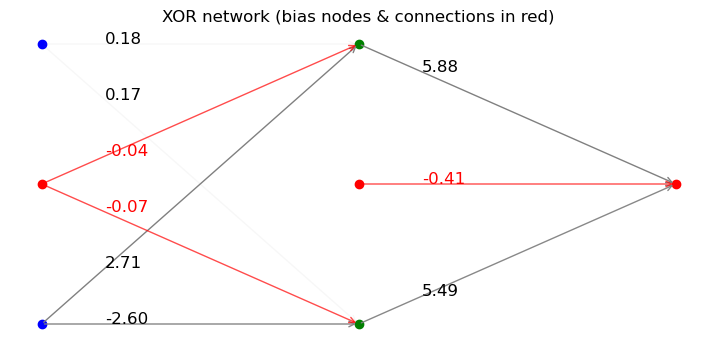

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_network_architecture_with_all_weights_and_biases(weights_input_hidden, 
                                                          bias_hidden, weights_hidden_output, bias_output,
                                                         fsize=12, lw=1):
    fig, ax = plt.subplots(figsize=(9, 4))

    
    # Normalize weights for alpha values
    fc1_weights_normalized = np.abs(weights_input_hidden) / np.max(np.abs(weights_input_hidden))
    fc2_weights_normalized = np.abs(weights_hidden_output) / np.max(np.abs(weights_hidden_output))

    # Neuron positions with aligned bias nodes
    input_neurons = [(1, 3), (1, 1)]
    hidden_neurons = [(2, 3), (2, 1)]
    output_neurons = [(3, 2)]
    bias_neurons = [(1, 2), (2, 2)]  # Aligned bias nodes with input and hidden nodes

    # Plot neurons
    for neuron in input_neurons + hidden_neurons + output_neurons:
        ax.plot(neuron[0], neuron[1], 'o', color='blue' if neuron in input_neurons else 'green' if neuron in hidden_neurons else 'red')

    # Connect input to hidden layer with weights
    for i, input_neuron in enumerate(input_neurons):
        for j, hidden_neuron in enumerate(hidden_neurons):
            weight = weights_input_hidden[i, j]
            alpha = fc1_weights_normalized[i, j]
            ax.annotate('', xy=hidden_neuron, xytext=input_neuron, arrowprops=dict(arrowstyle="->", lw=lw, color='gray', alpha=alpha))
            text_pos = np.array(input_neuron) + 0.2 * (np.array(hidden_neuron) - np.array(input_neuron))
            ax.text(*text_pos, f'{weight:.2f}', color='black', fontsize=fsize)

    # Connect hidden to output layer with weights
    for i, hidden_neuron in enumerate(hidden_neurons):
        weight = weights_hidden_output[i, 0]
        alpha = fc2_weights_normalized[i, 0]
        ax.annotate('', xy=output_neurons[0], xytext=hidden_neuron, arrowprops=dict(arrowstyle="->", lw=lw, color='gray', alpha=alpha))
        text_pos = np.array(hidden_neuron) + 0.2 * (np.array(output_neurons[0]) - np.array(hidden_neuron))
        ax.text(*text_pos, f'{weight:.2f}', color='black', fontsize=fsize)

    # Plot and connect bias nodes for hidden layer, include weights for bias to hidden neurons
    bias_neuron = bias_neurons[0]
    ax.plot(*bias_neuron, 'o', color='red')
    for i, hidden_neuron in enumerate(hidden_neurons):
        ax.annotate('', xy=hidden_neuron, xytext=bias_neuron, arrowprops=dict(arrowstyle="->", lw=lw, color='red', alpha=0.7))
        text_pos = np.array(bias_neuron) + 0.2 * (np.array(hidden_neuron) - np.array(bias_neuron))
        ax.text(*text_pos, f'{bias_hidden[0, i]:.2f}', color='red', fontsize=fsize)

    # Plot and connect bias node for output layer
    output_bias = bias_neurons[-1]
    ax.plot(*output_bias, 'o', color='red')
    ax.annotate('', xy=output_neurons[0], xytext=output_bias, arrowprops=dict(arrowstyle="->", lw=lw, color='red', alpha=0.7))
    text_pos = np.array(output_bias) + 0.2 * (np.array(output_neurons[0]) - np.array(output_bias))
    ax.text(*text_pos, f'{bias_output[0, 0]:.2f}', color='red', fontsize=fsize)

    ax.axis('off')
    plt.title("XOR network (bias nodes & connections in red)")

    # Print the weight matrices and bias vectors
    print("First Layer Weights:\n", weights_input_hidden)
    print("First Layer Biases:\n", bias_hidden)
    print("Second Layer Weights:\n", weights_hidden_output)
    print("Second Layer Biases:\n", bias_output)
    
    return fig

plt.close('all')
# To use the function, pass your network's weights and biases
network_plot = plot_network_architecture_with_all_weights_and_biases(weights_input_hidden, bias_hidden, weights_hidden_output, bias_output)
plt.show()


---

## <font color='red'>Lab questions, part 2</font>


5. Consider the weights you see in the network plot. Compare them to the weights we used when made the network that combines OR and NAND to implement XOR in the previous notebook. Note that the network is *possibly* but *not necessarily* implementing the same function. Keep in mind as well that at the hidden unit stage, it is applying the tanh activation function, and for the output node, it is applying the sigmoid activation function. 

    a. Try to work out what answer the network should give for the pairs [0,0], [0,1], [1,0], and [1,1]. Multiply those values by the input-to-hidden weights, add the bias-to-hidden weight, then approximately apply tanh. Do the same with the output node, but using sigmoid. Can you get approximately the values that the previous function reported for these weights? (I've now added a printout of hidden unit state values after the network trains. Think about what these imply...)

    b. Does the network seem to implement anything like simpler logical functions (AND, OR, NAND) at the hidden level and then at the output level? If so, what functions do you think it is approximating? 

**Challenge questions (required for grad students and honors students, optional for others) -- if these are required for you, do at least one.**

6. In the network training cell above, I had started trying to create an adaptive learning rate. I wanted the learning rate to start where the user specified it, and then decrease over training. What we really want is a kind of reverse sigmoid function, where the change will be very slow for a while and then change rapidly, and then slow down again and plateau at 10% of the original learning rate. Another way to go might be to do something that would be kind of like a reverse ReLu: keep the learning rate high for the first half of epochs and the decrease linearly down to 10% of the orignal value by the last epoch. I ran out of time and did not get this work. **Programming challenge**: Can you get an adaptive learning rate going? Look for this line as the place to start making changes. ```if lr_reduce is not None:```. If you can get one implemented, how does the network behave subsequently? Is it less likely to get stuck?

7. **Programming challenge**: The network plotting code above uses a lot of 'hard-coded' values. The numbers of nodes in each layer are stipulated. Can you modify the function to instead determine the number of nodes in each part of the network based on the shapes of the weight matrices? 

8. **Parameter exploration**. See what happens if you change the number of hidden nodes in the network. Just change the line `num_hidden = 2` to something like `num_hidden = 4`. Train the network a few times. What differences do you observe? Note that you will not be able to plot the resulting network unless you do #7. 


---

---

## <font color='purple'>Late addition that will help with lab questions: visualizing the transformations</font>

Run the cell below. It makes 3 plots.

Left: the XOR problem in the original input space. X = False, circle = True.

Middle: what raw inputs to the hidden units look like. 

Right: tanh-transformed values. 

This shows how the network translates the XOR problem from a non-linearly separable form to a linearly separable one. 


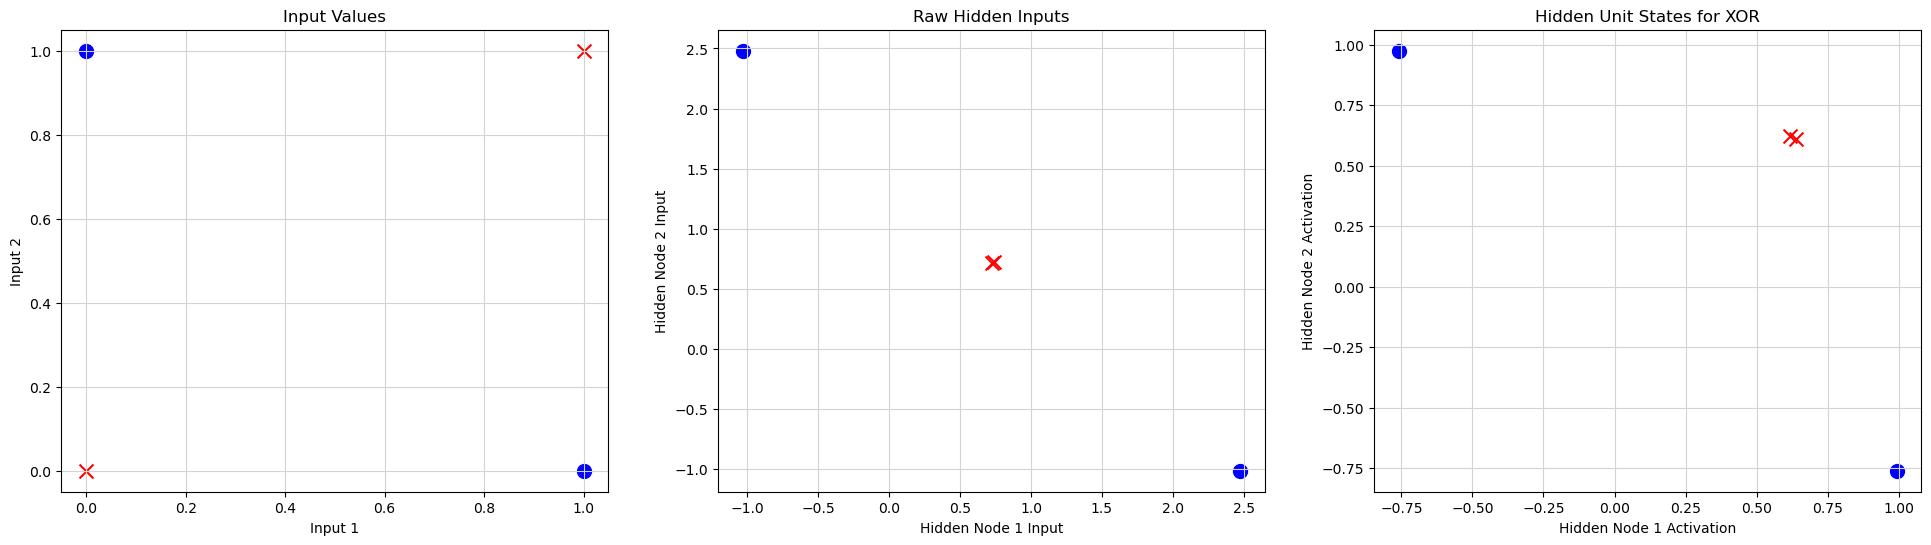

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hidden_states_and_inputs(inputs, hidden_states, hidden_inputs, outputs, ptitle='Hidden Unit States', jitter=0.0):
    """
    Plots the input values, raw hidden inputs, and the hidden unit states for given inputs and outputs.

    Parameters:
    inputs (np.array): Array of input points.
    hidden_states (np.array): Array of hidden states corresponding to each input point.
    hidden_inputs (np.array): Array of raw hidden inputs corresponding to each input point.
    outputs (np.array): Array of output values corresponding to each input point.
    jitter (float): Amount of jitter to apply to the points.
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # Three panels side by side

    # Plotting the input values
    ax = axes[0]
    for point, output in zip(inputs, outputs):
        color = 'blue' if output == 1 else 'red'
        marker = 'o' if output == 1 else 'x'
        ax.scatter(point[0], point[1], color=color, marker=marker, s=100)

    ax.set_title('Input Values')
    ax.set_xlabel('Input 1')
    ax.set_ylabel('Input 2')
    ax.grid(True, color='lightgrey')

    # Plotting the raw hidden inputs
    ax = axes[1]
    for point, hidden_input, output in zip(inputs, hidden_inputs, outputs):
        color = 'blue' if output == 1 else 'red'
        marker = 'o' if output == 1 else 'x'
        jittered_state = hidden_input + np.random.normal(0, jitter, hidden_input.shape)
        ax.scatter(jittered_state[0], jittered_state[1], color=color, marker=marker, s=100)

    ax.set_title('Raw Hidden Inputs')
    ax.set_xlabel('Hidden Node 1 Input')
    ax.set_ylabel('Hidden Node 2 Input')
    ax.grid(True, color='lightgrey')

    # Plotting the activated hidden states
    ax = axes[2]
    for point, hidden_state, output in zip(inputs, hidden_states, outputs):
        color = 'blue' if output == 1 else 'red'
        marker = 'o' if output == 1 else 'x'
        jittered_state = hidden_state + np.random.normal(0, jitter, hidden_state.shape)
        ax.scatter(jittered_state[0], jittered_state[1], color=color, marker=marker, s=100)

    ax.set_title(ptitle)
    ax.set_xlabel('Hidden Node 1 Activation')
    ax.set_ylabel('Hidden Node 2 Activation')
    ax.grid(True, color='lightgrey')

    plt.show()

# Example usage
plot_hidden_states_and_inputs(inputs, hidden_states_matrix, hidden_inputs_matrix, outputs, ptitle='Hidden Unit States for XOR', jitter=0.009)


## <font color='red'>Lab questions, part 3</font>

9. Train a few models until you get fairly different final weights. Paste in the network plots showing the weights. Compare the outcomes in terms of the Input vs. Raw hidden vs. (tanh) Hidden states plot directly above. Describe what you observe, and paste in screenshots of the state plots above for the 2 networks. 